In [83]:
import pandas as pd
import numpy as np
import json
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [84]:
# read in data

reg21_22 = pd.read_csv("clean_reg21_22.csv")
playoff21_22 = pd.read_csv("clean_playoff21_22.csv")
raptor_df = pd.read_csv("modern_RAPTOR_by_team.csv")


In [85]:
# Clean Data

# Keep specfic columns
columns_to_keep = ["player_name","season","season_type","team","poss","mp","raptor_offense","raptor_total",
                   "war_total","war_reg_season","war_playoffs","predator_offense","predator_total"]
raptor_df = raptor_df[columns_to_keep]
raptor_df.head()

,player_name,season,season_type,team,poss,mp,raptor_offense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_total
0,Alex Abrines,2017,PO,OKC,172,80,-0.892617,-7.453875,-0.198700,0.000000,-0.198700,-3.298178,-9.833292
1,Alex Abrines,2017,RS,OKC,2215,1055,0.654933,-0.069300,1.447708,1.447708,0.000000,0.339201,-0.272665
2,Alex Abrines,2018,PO,OKC,233,110,1.875157,2.615450,0.311392,0.000000,0.311392,2.877519,2.356566
3,Alex Abrines,2018,RS,OKC,2313,1134,-0.211818,-1.940401,0.465912,0.465912,0.000000,-0.482078,-1.654306
4,Alex Abrines,2019,RS,OKC,1279,588,-4.040157,-2.154538,0.178167,0.178167,0.000000,-4.577678,-3.034396


In [86]:
# Get Just 2021-2022 Season

raptor_df_2022 = raptor_df[raptor_df["season"] == 2022]
raptor_df_2022

,player_name,season,season_type,team,poss,mp,raptor_offense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_total
7,Precious Achiuwa,2022,PO,TOR,320,167,-2.531130,-3.286191,-0.046953,0.000000,-0.046953,-3.958067,-4.409724
8,Precious Achiuwa,2022,RS,TOR,3482,1725,-2.516108,-0.105515,2.309611,2.309611,0.000000,-2.348484,-0.096575
37,Steven Adams,2022,PO,MEM,245,114,1.708276,-0.699908,0.123000,0.000000,0.123000,0.620153,-2.306824
38,Steven Adams,2022,RS,MEM,4147,1999,1.684133,2.303361,5.140587,5.140587,0.000000,1.417837,3.207289
46,Bam Adebayo,2022,PO,MIA,1197,614,0.812913,4.085476,2.172589,0.000000,2.172589,0.093798,3.393456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7244,Trae Young,2022,RS,ATL,5536,2652,7.615987,4.417909,9.903858,9.903858,0.000000,7.257725,3.863434
7245,Omer Yurtseven,2022,PO,MIA,80,38,-0.384915,-0.926403,0.036325,0.000000,0.036325,-1.215995,-3.846854
7246,Omer Yurtseven,2022,RS,MIA,1445,706,-2.141570,-1.186370,0.563127,0.563127,0.000000,-2.314126,-1.982086
7257,Cody Zeller,2022,RS,POR,748,355,-0.222446,-3.449202,-0.127035,-0.127035,0.000000,-0.396488,-2.797523


In [87]:
# Renaming 'vorp' in data frames so they can merge

reg21_22 = reg21_22.rename(columns={'VORP': 'vorp_reg'})
playoff21_22 = playoff21_22.rename(columns={'VORP': 'vorp_post'})

# changing name of player column in raptor to join
raptor_df_2022 = raptor_df_2022.rename(columns={'player_name': 'Player', 'Tm': 'team'})

# filter reg season players by 1000 minutes played
reg21_22 = reg21_22[reg21_22['MP'] > 1000]

# Performing the joins
result = pd.merge(raptor_df_2022, reg21_22, on='Player', how='inner')
result = pd.merge(result, playoff21_22, on='Player', how='inner')

In [88]:
# keeping the varaibles we want and dropping everything else

columns_to_keep = ['Player', 'season', 'season_type', 'team', 'mp', 'raptor_total', 'war_total', 'predator_total', 'vorp_reg', 'vorp_post', 'G_y']
result = result[columns_to_keep]

In [89]:
# Filter post-season players with more than 20 post_mpg

result['post_mpg'] = result['mp']/result['G_y']
result.loc[result['season_type'] == 'RS', 'post_mpg'] = pd.NA
filtered_post_season_players = result[(result['season_type'] == 'PO') & (result['post_mpg'] >= 10)]

# Concatenate the regular-season players with the filtered post-season players

final_result = pd.concat([result[result['season_type'] == 'RS'], filtered_post_season_players])
final_result.to_csv("master.csv", index = False)

# split into reg and post data frames
final_result_reg = final_result[final_result['season_type'] == 'RS']
final_result_post = final_result[final_result['season_type'] == 'PO']

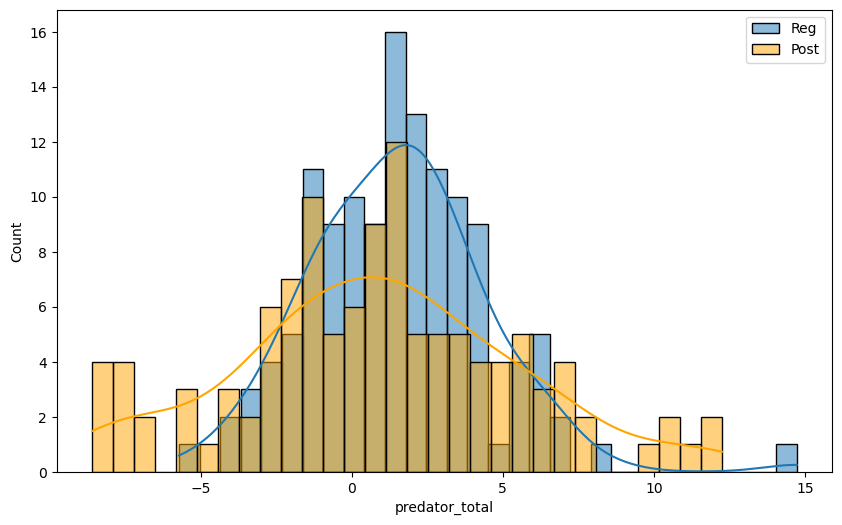

In [90]:
plt.figure(figsize=(10, 6))
sns.histplot(data=final_result_reg, x='predator_total', bins=30, kde=True, label='Reg')
sns.histplot(data=final_result_post, x='predator_total', bins=30, kde=True, color='orange', label='Post')
plt.legend()
plt.show()

In [91]:
# gettitng differences in metrics

# Master df
master_df = pd.merge(final_result_reg, final_result_post, on='Player', suffixes=('_reg', '_post'))

# Calculate the differences for each metric
master_df['raptor_diff'] = abs(master_df['raptor_total_reg'] - master_df['raptor_total_post'])
master_df['predator_diff'] = abs(master_df['predator_total_reg'] - master_df['predator_total_post'])

master_df = master_df[['Player', 'raptor_diff', 'predator_diff']]
master_df

,Player,raptor_diff,predator_diff
0,Steven Adams,3.003268,5.514113
1,Bam Adebayo,0.304554,0.426445
2,Grayson Allen,1.529447,2.282209
3,Kyle Anderson,0.069871,1.164892
4,Giannis Antetokounmpo,1.937522,0.595818
...,...,...,...
112,Andrew Wiggins,4.491960,5.005065
113,Grant Williams,1.219042,2.848730
114,Ziaire Williams,0.697606,0.027551
115,Delon Wright,7.857374,5.716774


In [92]:
master_df.sort_values(by='raptor_diff', ascending=False)

,Player,raptor_diff,predator_diff
36,Kevin Durant,15.208962,12.076307
116,Trae Young,12.095008,11.205985
29,Mike Conley,10.840862,12.664307
51,Tyler Herro,8.826299,8.733090
84,Cameron Payne,8.218411,8.867336
...,...,...,...
94,Duncan Robinson,0.214471,1.288315
20,Troy Brown Jr.,0.137679,2.341811
19,Jaylen Brown,0.108597,0.814747
86,Jordan Poole,0.104219,0.106118


In [93]:
master_df.sort_values(by='predator_diff', ascending=False)

,Player,raptor_diff,predator_diff
29,Mike Conley,10.840862,12.664307
36,Kevin Durant,15.208962,12.076307
116,Trae Young,12.095008,11.205985
93,Austin Rivers,7.863527,9.510622
84,Cameron Payne,8.218411,8.867336
...,...,...,...
83,Chris Paul,2.273474,0.065063
44,Danny Green,1.082383,0.043616
76,Patty Mills,1.329910,0.031375
114,Ziaire Williams,0.697606,0.027551


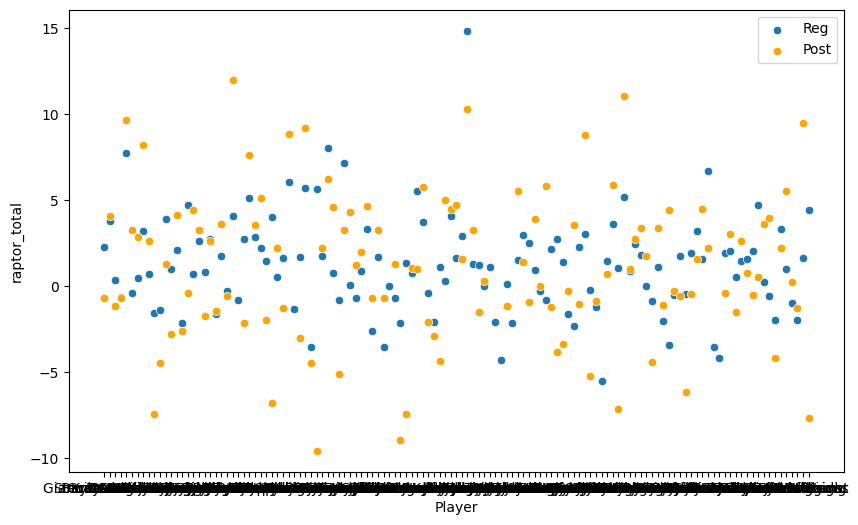

In [94]:
# Define the list of players you want to include in the scatter plot
# selected_players = ['Kevin Durant',"Trae Young","Otto Porter Jr.", "Luka Doncic"]  # Replace with the actual player names you want

# Filter the dataframes based on selected players
# filtered_result_reg = final_result_reg[final_result_reg['Player'].isin(selected_players)]
# filtered_result_post = final_result_post[final_result_post['Player'].isin(selected_players)]

plt.figure(figsize=(10, 6))

# Scatter plot for 'filtered_result_reg'
sns.scatterplot(data= final_result_reg, x='Player', y='raptor_total', label='Reg')

# Scatter plot for 'filtered_result_post'
sns.scatterplot(data=final_result_post, x='Player', y='raptor_total', color='orange', label='Post')

plt.legend()
plt.show()

In [110]:
# NEW IDEA, REGRESSION OF EVERY PLAYER WHERE THEY MADE POSTSEASON
# USE VARAIBLES LIKE AGE, YEARS IN LEAGUE, YEARS IN POSTSEASON

raptor_df.head()

# Create a DataFrame
df = pd.DataFrame(raptor_df, columns=['player_name', 'season', 'season_type', 'raptor_total', 'war_total', 'predator_total'])

# Sorting the dataframe by player and season
df = df.sort_values(by=['player_name', 'season'])

# Creating columns for years in the league and years in playoff
df['years_league'] = df.groupby('player_name').cumcount() + 1
df['years_playoff'] = df[df['season_type'] == 'PO'].groupby('player_name').cumcount() + 1

# Filling NaN values in 'years_in_playoff' with 0, indicating no playoff experience in those seasons
df['years_playoff'] = df['years_playoff'].fillna(0).astype(int)

# Update 'Years_playoff' for 'RS' rows to match 'PO' rows in the same season
for index, row in df.iterrows():
    if row['season_type'] == 'RS':
        po_row = df.loc[(df['player_name'] == row['player_name']) & (df['season'] == row['season']) & (df['season_type'] == 'PO')]
        if not po_row.empty:
            df.loc[index, 'years_playoff'] = po_row['years_playoff'].values[0]

df

,player_name,season,season_type,raptor_total,war_total,predator_total,years_league,years_playoff
2673,AJ Hammons,2017,RS,-8.979102,-0.515632,-10.376982,1,0
5573,AJ Price,2014,RS,-2.402681,0.017381,-5.825418,1,0
5574,AJ Price,2015,RS,-5.535939,-0.121218,-4.640239,2,0
5575,AJ Price,2015,RS,6.024449,0.845180,2.779264,3,0
5576,AJ Price,2015,RS,-11.200129,-0.186722,-7.588440,4,0
...,...,...,...,...,...,...,...,...
7115,Zion Williamson,2021,RS,2.965017,5.983387,2.020089,2,0
1856,Zoran Dragic,2015,RS,-12.382279,-0.308171,-11.316123,1,0
1857,Zoran Dragic,2015,RS,-8.408173,-0.037635,-7.099639,2,0
1264,Zylan Cheatham,2020,RS,-13.750013,-0.285514,-12.631342,1,0


In [113]:
# changing name of player column in raptor to join
df = df.rename(columns={'player_name': 'Player', 'Tm': 'team'})

# Performing the joins
df_merge = pd.merge(df, reg21_22, on='Player', how='inner')
df_merge = pd.merge(df_merge, playoff21_22, on='Player', how='inner')

columns_to_keep = ['Player', 'Age_x', 'season', 'season_type', 'raptor_total', 'war_total', 'predator_total', 'years_league', 'years_playoff']
final = df_merge[columns_to_keep]
final = final.rename(columns={'Age_x': 'Age'})

# filter for RS and PO in same year
final = final.groupby(['Player', 'season']).filter(lambda x: 'RS' in x['season_type'].values and 'PO' in x['season_type'].values)

final

,Player,Age,season,season_type,raptor_total,war_total,predator_total,years_league,years_playoff
4,Aaron Gordon,26,2019,PO,-4.986688,-0.193883,-2.971293,5,1
5,Aaron Gordon,26,2019,RS,0.700352,4.616578,0.266693,6,1
7,Aaron Gordon,26,2021,PO,-1.289513,0.231974,-3.131051,8,2
8,Aaron Gordon,26,2021,RS,-0.267922,0.821301,0.043289,9,2
9,Aaron Gordon,26,2021,RS,1.558912,1.619684,-0.405708,10,2
...,...,...,...,...,...,...,...,...,...
1239,Will Barton,31,2022,RS,-1.538424,1.405970,-1.328352,14,4
1247,Zach LaVine,26,2022,PO,-1.167938,0.126198,-2.973468,8,1
1248,Zach LaVine,26,2022,RS,0.160157,3.462442,-0.016570,9,1
1249,Ziaire Williams,20,2022,PO,-1.278431,0.132003,-0.896287,1,1


In [115]:
# creating normalized general performance metric

final_reg = final[final['season_type'] == 'RS']
final_post = final[final['season_type'] == 'PO']

metrics = ['raptor_total', 'war_total', 'predator_total']  # Replace with actual metric names
scaler = MinMaxScaler()

final_reg_norm = final_reg.copy()
final_post_norm = final_post.copy()

final_reg_norm[metrics] = scaler.fit_transform(final_reg[metrics])
final_post_norm[metrics] = scaler.fit_transform(final_post[metrics])

final_reg_norm['performance_score'] = final_reg_norm[metrics].sum(axis=1)
final_post_norm['performance_score'] = final_post_norm[metrics].sum(axis=1)

# Filter out duplicates for players with two 'RS' rows in the same season
final_reg_norm = final_reg_norm[~((final_reg_norm['season_type'] == 'RS') & final_reg_norm.duplicated(subset=['Player', 'season']))]

final_reg_norm

,Player,Age,season,season_type,raptor_total,war_total,predator_total,years_league,years_playoff,performance_score
5,Aaron Gordon,26,2019,RS,0.536522,0.251080,0.453885,6,1,1.241487
8,Aaron Gordon,26,2021,RS,0.504841,0.101817,0.445635,9,2,1.052293
11,Aaron Gordon,26,2022,RS,0.516960,0.205432,0.432323,12,3,1.154715
14,Al Horford,35,2015,RS,0.579758,0.289841,0.511143,3,1,1.380741
16,Al Horford,35,2016,RS,0.563554,0.295275,0.512632,5,2,1.371461
...,...,...,...,...,...,...,...,...,...,...
1234,Will Barton,31,2019,RS,0.390830,0.045574,0.328669,9,2,0.765073
1237,Will Barton,31,2021,RS,0.447874,0.095207,0.375756,12,3,0.918837
1239,Will Barton,31,2022,RS,0.463270,0.124812,0.394982,14,4,0.983064
1248,Zach LaVine,26,2022,RS,0.518847,0.205689,0.443425,9,1,1.167961


In [119]:
# REGRESSION

# Select relevant columns for X and y
X = final_reg_norm[['Age', 'performance_score', 'years_league', 'years_playoff']]
y = final_post_norm[['performance_score']]

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.09608318360694403
R-squared: 0.2947962665010805


In [120]:
# coefficents

feature_importance = model.coef_ 
feature_importance

array([[ 0.00277977,  0.50765043, -0.01312136,  0.03402541]])